In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
from topo_util import noisy_circle
import sklearn as sk
import sklearn.decomposition
import math
import pd

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
np.random.seed(42)
data1 = noisy_circle(50, 0.2, 0, 0, 3 )
data2 = noisy_circle(50, 0.2, 8, 0, 5)
data3 = noisy_circle(50, 0.2, 4, 15, 4 )
A = np.concatenate([data1, data2, data3])
data1 = noisy_circle(50, 0.2, 0, 0, 3 )
data2 = noisy_circle(50, 0.2, 7, 0, 4)
data3 = noisy_circle(50, 0.2, 4, 15, 5 )
B = np.concatenate([data1, data2, data3])


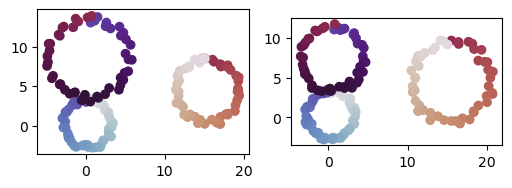

In [3]:
plt.figure(figsize = (6, 3))
plt.subplot(1, 2, 1)
plt.scatter(A[:,1],A[:,0], c = range(A.shape[0]), cmap = 'twilight')
plt.gca().set_aspect('equal', adjustable='box')
plt.subplot(1, 2, 2)
plt.scatter(B[:,1],B[:,0], c = range(B.shape[0]), cmap = 'twilight')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [4]:
def PH(X):
    df = pandas.DataFrame()
    for ii in range(X.shape[1]):
        df['x_{}'.format(ii)] =  X[:,ii]
    df.to_csv("pointcloud.tsv", sep = '\t', index = False)
    !julia ../src/PH.jl 
    with open('PH.json','r') as f:
        dic = json.load(f)
    return dic 

In [5]:
H_all = [PH(x) for x in tqdm([A,B])]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:22<00:00, 11.13s/it]


In [6]:
df1 = topo_util.make_dataframe(H_all[0]["barcode"])
df2 = topo_util.make_dataframe(H_all[1]["barcode"])

In [7]:
import ot
p_spt = df1.iloc[:, 0:2].to_numpy()
q_spt = df2.iloc[:, 0:2].to_numpy()
p, q = pd.augmented_weights(p_spt, q_spt)
C = pd.augmented_cost(p_spt, q_spt)
pi = ot.emd(p, q, C)

In [8]:
import matplotlib.pyplot as plt
import importlib
import numpy as np
from tqdm import tqdm
import hypernetx as hnx
import tpot

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [9]:
G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]

In [10]:
y0, w0, v0 = topo_util.process_hg(G_all[0], A.shape[0])
y1, w1, v1 = topo_util.process_hg(G_all[1], B.shape[0])

In [11]:
# similarity with kernel
h = 0.25
K0 = topo_util.get_kernel(A, h)
L0 = topo_util.symmetric_laplacian(K0)
K0 /= K0.sum(-1).reshape(-1, 1)
K1 = topo_util.get_kernel(B, h)
L1 = topo_util.symmetric_laplacian(K1)
K1 /= K1.sum(-1).reshape(-1, 1)

In [12]:
y0_imputed = topo_util.impute_laplacian(y0, L0)
y1_imputed = topo_util.impute_laplacian(y1, L1)

In [13]:
y0 = y0_imputed; y1 = y1_imputed;

In [14]:
C_v0 = sp.spatial.distance.cdist(A, A, metric = "euclidean"); C_v0 /= np.mean(C_v0)
# C_v0 = np.exp(-C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "euclidean"); C_v1 /= np.mean(C_v1)
# C_v1 = np.exp(-C_v1)
C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= np.mean(C_pd)

In [15]:
alpha = 0.5
v0 = p
v1 = q
importlib.reload(tpot)
pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1,
                          C_v0, C_v1, C_pd, 
                          alpha = alpha, beta = 1, print_iter = 10, iter = 100, 
                          eps_s = 0.005, eps_f = 0.005,
                          solver = "sinkhorn",
                          )

Iteration 0,	 obj = 0.14264954210411218,	 obj_terms = {'coot': 0.0400334404833369, 'ot': 0.0005570606707695598, 'gw': 0.1020590409500057}
Iteration 10,	 obj = 0.03171471045192678,	 obj_terms = {'coot': 0.004193989381053361, 'ot': 0.01835693428022816, 'gw': 0.009163786790645256}
Iteration 20,	 obj = 0.03171377808464176,	 obj_terms = {'coot': 0.004193591988545778, 'ot': 0.01835694390262871, 'gw': 0.009163242193467269}
Iteration 30,	 obj = 0.03171370331697944,	 obj_terms = {'coot': 0.004193593282636925, 'ot': 0.018356943707159522, 'gw': 0.00916316632718299}
Iteration 40,	 obj = 0.031713657681120125,	 obj_terms = {'coot': 0.0041935940976229776, 'ot': 0.018356943588181154, 'gw': 0.009163119995315995}
Iteration 50,	 obj = 0.031713626903077934,	 obj_terms = {'coot': 0.00419359464201414, 'ot': 0.018356943508725194, 'gw': 0.009163088752338601}
Iteration 60,	 obj = 0.03171360474389061,	 obj_terms = {'coot': 0.004193595031405857, 'ot': 0.018356943451905302, 'gw': 0.009163066260579451}
Iteration 7

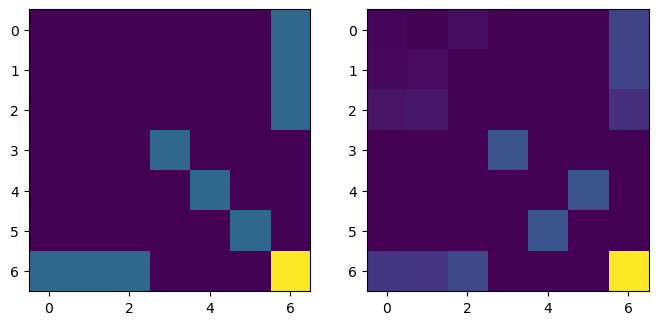

In [16]:
plt.subplot(1, 2, 2)
plt.imshow(pi_f)
plt.subplot(1, 2, 1)
plt.imshow(pi)

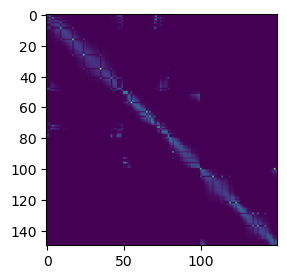

In [17]:
plt.figure(figsize = (3, 3))
plt.imshow(pi_s)

In [18]:
P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
Q_pd = pi[:-1, :-1] / pi[:-1, :-1].sum(axis=-1)[:, np.newaxis]
Q[np.isnan(Q)] = 0
Q_pd[np.isnan(Q_pd)] = 0

/tmp/ipykernel_682548/3284110093.py:3: RuntimeWarning:

invalid value encountered in divide



In [19]:
len(p_spt), len(q_spt)

(6, 6)

In [20]:
sizes_p = 10 + np.zeros((len(p_spt)))
sizes_q = 10 + np.zeros((len(q_spt)))
sizes_p[-1], sizes_p[-2],sizes_p[-3] = 100,100,100
sizes_q[-1], sizes_q[-2],sizes_q[-3] = 100,100,100

color_p =  np.zeros((len(p_spt)))
color_q =  np.zeros((len(q_spt)))
color_p[-1], color_p[-2],color_p[-3] = 1,2,3
color_q[-1], color_q[-2],color_q[-3] = 1,2,3

Text(0.5, 1.0, 'Geometric cycle matching')

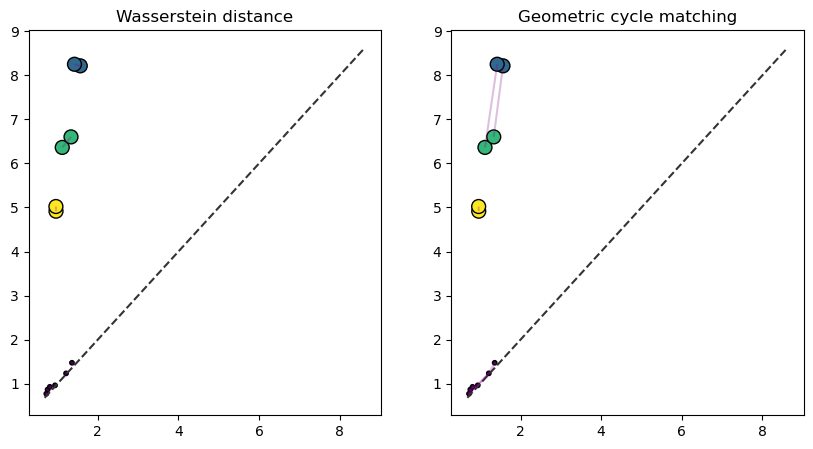

In [21]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
pd.plot_pd_connections(p, q, p_spt, q_spt, pi, color_p, color_q, sizes_p, sizes_q)
plt.title("Wasserstein distance")
plt.subplot(1, 2, 2)
pd.plot_pd_connections(p, q, p_spt, q_spt, pi_f, color_p, color_q, sizes_p, sizes_q)
plt.title("Geometric cycle matching")
# plt.savefig('outputs/mathcing_ex4.svg', dpi=300)

In [22]:
colour_source = list(np.zeros((len(A),)))
colour_target = list(np.zeros((len(A),)))
for l in range(1,4):
    index_source = np.where((y0[:, -l] >0.5 ))[0]
    for el in index_source:
        colour_source[el] =  l
    index_target = np.where((y1[:, -l] >0.5 ))[0]
    for el in index_target:
        colour_target[el] = l

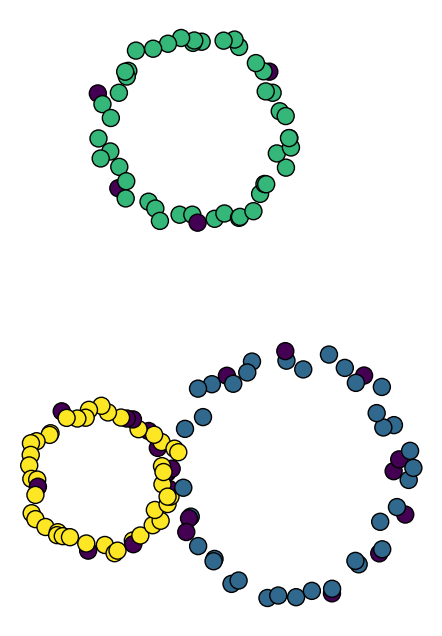

In [23]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(A[:,0],A[:,1],c = colour_source, s=150,edgecolors='black', vmax=3, vmin=0)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/source_ex4.svg', dpi=300)
plt.show()

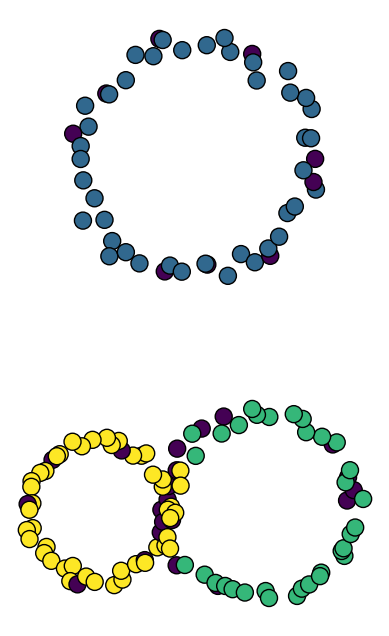

In [24]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(B[:,0],B[:,1],c = colour_target, s=150,edgecolors='black', vmax=3, vmin=0)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/target_ex4.svg', dpi=300)
plt.show()